In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Part A: Classification Problem**

In [ ]:
import os
os.chdir('/content/drive/MyDrive/CZ4042')

In [ ]:
import time
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler, Callback

In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

## **Preprocessing Data**

In [ ]:
df = pd.read_csv('./full.csv') 
df['label'] = df['filename'].str.split('_').str[-2]
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,label
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803,neg
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572,neg
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824,neg
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389,neg
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966,neg


In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

## **Split and scale dataset**

In [ ]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

# **Q2.**

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find
the optimal batch size for mini-batch gradient descent by training the neural network and
evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on
training partition to perform hyperparameter selection.
You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

Note: use this optimal batch size for the rest of the experiments.

In [ ]:
X_train, Y_train, X_test, Y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=0) # positive labels being encoded as 1
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# input to perform cross-validation
X = np.array(X_train_scaled)
Y = np.array(Y_train)

The data split ratio is rescaled to 80:20 instead of 70:30 as Question 1. As in this question, we apply 5-fold cross-validation, which means for each of 5 experiments, use 4 folds for training and the remaining one-fold for testing, we need to guarantee the validation data (test data in each fold) and test data have similar scale. If we use 80:20 ratio, the size of validation and test data is 16% and 20% of total data respectively while in 70:30 ratio case, such percentages are 14% and 30%.



####**a) Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. This might take a while to run.**

As we use 5-fold cross-validation on training partition to perform hyperparameter selection, we will use training dataset X_train_scaled, Y_train only to select the combination of hyperparameters gives the best model performance.


In [ ]:
# callback to compute training time for each epoch
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
te = time_for_epoch()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
l_r = 0.001
epochs = 100
num_neurons = 128
drop_out = 0.2
no_folds = 5
batch_size_list = [128, 256, 512, 1024]

In [ ]:
import collections
# dictionary to map the batch size with its average accuracy and loss and time taken to train the whole network
val_acc_bs  = collections.defaultdict(list)
val_loss_bs = collections.defaultdict(list)
time_bs = collections.defaultdict(list)

In [ ]:
with tf.device('/device:GPU:0'):
  # i = batch size, for each batch size, go through the 5-fold validation
  for bs in batch_size_list:
    print("----- BATCH SIZE: %d -----" %bs)
    fold = 0
    val_acc_per_fold = []                 # list to store the accuracy in each fold
    val_loss_per_fold = []                # list to store the loss in each fold
    cb_per_fold = []                      # list to store the training time on last epoch in each fold
    cv = KFold(n_splits=no_folds, shuffle=True, random_state=1)
    for train_idx, test_idx in cv.split(X,Y):
        x_train, y_train  = X[train_idx], Y[train_idx]
        x_test, y_test = X[test_idx], Y[test_idx]
        print(f'Training for fold {fold+1} ...')

        model = keras.Sequential([
                  Dense(num_neurons, activation='relu'),
                  Dropout(drop_out),
                  Dense(num_neurons, activation='relu'),
                  Dropout(drop_out),
                  Dense(num_neurons, activation='relu'),
                  Dropout(drop_out),
                  Dense(1, activation='sigmoid')])
        
        opt = keras.optimizers.Adam(l_r)
        model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
        
        history = model.fit(x_train, y_train,
                            epochs=epochs,
                            verbose=0,
                            use_multiprocessing=True,
                            batch_size = bs,
                            callbacks = [te,early_stopping],
                            validation_data=(x_test, y_test))
        
        # Save the validation accuracy and loss for last epoch each fold to compute the mean value to evaluate 
        val_acc = history.history['val_binary_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]

        val_acc_per_fold.append(val_acc)
        val_loss_per_fold.append(val_loss)
        cb_per_fold.append(te.times[-1])

        # Log the results
        print('Fold %d: model loss - %.3f; model accuracy - %.2f' %(fold+1, val_loss, val_acc*100))
        print("Training time on last epoch:", te.times[-1])
        fold += 1
    val_acc_bs[bs] = val_acc_per_fold
    val_loss_bs[bs] = val_loss_per_fold
    time_bs[bs] = cb_per_fold

    # Log the results
    print('Average of validation accuracy %.3f' %np.mean(val_acc_per_fold))
    print("Time taken to train the network on the last epoch: %.3f" %np.mean(cb_per_fold))
    print('------------------------------------------------------------------------')

----- BATCH SIZE: 128 -----
Training for fold 1 ...
Fold 1: model loss - 0.611; model accuracy - 65.70
Training time: 3.283665657043457
Training for fold 2 ...
Fold 2: model loss - 0.609; model accuracy - 65.53
Training time: 3.358668804168701
Training for fold 3 ...
Fold 3: model loss - 0.611; model accuracy - 65.53
Training time: 3.2253835201263428
Training for fold 4 ...
Fold 4: model loss - 0.607; model accuracy - 65.90
Training time: 3.569995641708374
Training for fold 5 ...
Fold 5: model loss - 0.606; model accuracy - 66.17
Training time: 3.347219705581665
Average of validation accuracy 0.658
Time taken to train the network on the last epoch: 3.357
------------------------------------------------------------------------
----- BATCH SIZE: 256 -----
Training for fold 1 ...
Fold 1: model loss - 0.601; model accuracy - 66.24
Training time: 2.6516964435577393
Training for fold 2 ...
Fold 2: model loss - 0.604; model accuracy - 65.90
Training time: 2.854808807373047
Training for fold 3

We create tables to report the validation accuracy and loss and time taken with according fold and batch size.

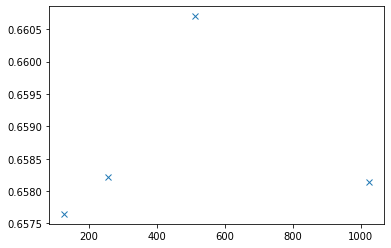

In [ ]:
mean_acc = [np.mean(val_acc_bs[i]) for i in batch_size_list]
plt.plot(batch_size_list, mean_acc, marker = 'x', linestyle = 'None')

####**b) Create a table of time taken to train the network on the last epoch against different batch sizes. (Hint: Introduce a callback)**

In [ ]:
train_time = collections.defaultdict(list)
for bs in batch_size_list:
  print("----- BATCH SIZE: %d -----" %bs)
  print("Average training time:", np.mean(time_bs[bs]))
  train_time[bs] = np.mean(time_bs[bs])

----- BATCH SIZE: 128 -----
Average training time: 3.356986665725708
----- BATCH SIZE: 256 -----
Average training time: 2.7235958099365236
----- BATCH SIZE: 512 -----
Average training time: 2.0165249824523928
----- BATCH SIZE: 1024 -----
Average training time: 1.7120765209198


####**c) Select the optimal batch size and state a reason for your selection.**

To choose optimal batch size, we consider both accuracy and training time.

It is expected that the smaller batch size will give better generalization, hence, the validation accuracy should be higher for smaller batch size. Based on the reported mean accuracy, models with batch size of 256 and 512 perform slightly better than others.
Besides, a larger batch size allows computational speedups from the parallelism of GPUs. Our reported training time also shows that the time is reduced almost half each time we increase half of the batch size. The 2 batch size 512 and 1024 give the fastest training times.

Based on overall performance on both accuracy and training time, the optimal batch size is 512 which give almost best accuracy while it still takes less time to train.

####**d) What happens when batch size increases, and why does it happen?**

The model with large batch size tend to converge to sharp minimizers of the training and testing functions–and that sharp minima lead to poorer generalization. In contrast, small-batch methods consistently converge to flat minimizers. Gradient with small batch size oscillates much more compared to larger batch size. 

To conclude, larger batches lead to less training time but it may have less generalization and not perform well on test size.




####**e) Plot the train and test accuracies against epochs for the optimal batch size in a line plot.**

In [ ]:
opt_bs = 512

model = keras.Sequential([
                  Dense(num_neurons, activation='relu'),
                  Dropout(drop_out),
                  Dense(num_neurons, activation='relu'),
                  Dropout(drop_out),
                  Dense(num_neurons, activation='relu'),
                  Dropout(drop_out),
                  Dense(1, activation='sigmoid')])
        
opt = keras.optimizers.Adam(l_r)
model.compile(optimizer=opt,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(X_train_scaled, Y_train,
                    epochs=epochs,
                    verbose=0,
                    use_multiprocessing=True,
                    batch_size = opt_bs,
                    callbacks = [te,early_stopping],
                    validation_data=(X_test_scaled, Y_test))

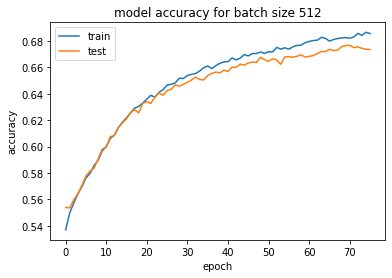

In [ ]:
plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='testing')
plt.title('Model accuracy for batch size %d'%(opt_bs))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The generalization gap between training and test accuracy is improved with less than 3% and kept stable. With the use of EarlyStopping callback, the training will stop at the epoch where overfitting starts occur. It can conclude that with new optimal batch size, the model avoids slightly overfitting compared to previous part. 